In [1]:
from helpers import *
from dataset import *
from model2 import *
from czii_helper import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import torchvision.transforms as T
import cv2
import math
import cc3d
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, NormalizeIntensityd, ToTensorD
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
DEBAG = False

In [3]:
mask_size2 = {k: 2 for k in mask_size}
mask_size2

{'defolt': 2,
 'apo-ferritin': 2,
 'beta-amylase': 2,
 'beta-galactosidase': 2,
 'ribosome': 2,
 'thyroglobulin': 2,
 'virus-like-particle': 2}

In [4]:
MODE = 'local'
valid_dir = '../input/czii-cryo-et-object-identification/train'

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00010164-extern.pth',
   # '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.05,
    },
)

(6, 184, 630, 630)
(6, 184, 630, 630)


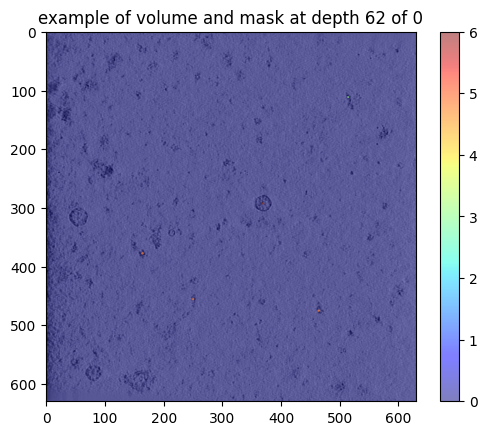

In [5]:
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

valid_id = ['TS_99_9', "TS_6_4", "TS_6_6", "TS_69_2", "TS_73_6", "TS_86_3"]
if DEBAG:
    valid_id = ["TS_5_4"]
test_id = ["TS_99_9"]

volumes = np.empty((len(valid_id), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id), 184, 630, 630), dtype=np.uint8)

for idx in range(len(valid_id)):
    data = read_one_data(valid_id[idx], train_dir)
    data = data.astype(np.float32)
    volumes[idx, :, :, :] = data
    
    y = read_one_truth(valid_id[idx], mask_dir)
    mask_data = generate_mask(y, mask_size2)
    mask_data = mask_data.astype(np.uint8)
    masks[idx, :, :, :] = mask_data

print(volumes.shape)
print(masks.shape)

print_slices(volumes, masks,dim=4,idx=0,depth=62)

In [6]:
vol_data = []
mask_data = []
for exp in range(len(valid_id)):
    vol_slices_list = []
    mask_slices_list = []

    volume = volumes[exp, :, :, :]
    mask = masks[exp, :, :, :]
    print("exp=", exp)
    
    #何もなし
    vol_slices,mask_slices=process_rotation_and_slicing(volume, mask, anglex=0, angley=0, anglez=0, zz_range=range(48, 184, 16))
    vol_slices_list.append(vol_slices)
    mask_slices_list.append(mask_slices)
    print("vol_slices shape:", vol_slices.shape)
    if DEBAG:
        combined_vol_slices = np.concatenate(vol_slices_list, axis=0)
        combined_mask_slices = np.concatenate(mask_slices_list, axis=0)

        vol_data.append(combined_vol_slices)
        mask_data.append(combined_mask_slices)
        continue
    # 180度回転
    vol_slices,mask_slices=process_rotation_and_slicing(volume, mask, anglex=180, angley=0, anglez=0, zz_range=range(48, 184, 16))
    vol_slices_list.append(vol_slices)
    mask_slices_list.append(mask_slices)
    print("vol_slices shape:", vol_slices.shape)

    #反転
    vol_slices,mask_slices=process_rotation_and_slicing(volume, mask, anglex=180, angley=180, anglez=0, zz_range=range(48, 136, 16))
    vol_slices_list.append(vol_slices)
    mask_slices_list.append(mask_slices)
    print("vol_slices shape:", vol_slices.shape)

    #斜め
    vol_slices,mask_slices=process_rotation_and_slicing(volume, mask, anglex=5, angley=5, anglez=5, zz_range=range(48, 184, 16))
    vol_slices_list.append(vol_slices)
    mask_slices_list.append(mask_slices)
    print("vol_slices shape:", vol_slices.shape)


    combined_vol_slices = np.concatenate(vol_slices_list, axis=0)
    combined_mask_slices = np.concatenate(mask_slices_list, axis=0)

    vol_data.append(combined_vol_slices)
    mask_data.append(combined_mask_slices)

vol_data = np.concatenate(vol_data, axis=0)
mask_data = np.concatenate(mask_data, axis=0)

print("vol_data shape:", vol_data.shape)
print("mask_data shape:", mask_data.shape)

exp= 0
-34 4 44
54 -11 28
-55 -60 12
-13 94 -4
-20 100 -20
-84 -13 -36
-58 -11 -52
-90 21 -68
86 -99 -84
vol_slices shape: (9, 32, 640, 640)
83 52 44
-21 -36 28
-5 6 12
79 -27 -4
-10 -31 -20
2 61 -36
85 94 -52
-28 44 -68
10 24 -84
vol_slices shape: (9, 32, 640, 640)
-56 45 44
-72 11 28
-43 -99 12
36 0 -4
41 68 -20
-100 -83 -36
vol_slices shape: (6, 32, 640, 640)
41 -22 44
87 -66 28
-35 5 12
94 -65 -4
-32 64 -20
6 -58 -36
-60 -69 -52
51 9 -68
29 -16 -84
vol_slices shape: (9, 32, 640, 640)
exp= 1
55 18 44
97 58 28
9 -42 12
48 -44 -4
-60 91 -20
50 -98 -36
-48 55 -52
91 3 -68
82 -99 -84
vol_slices shape: (9, 32, 640, 640)
71 95 44
-50 -91 28
-99 10 12
43 -12 -4
-14 -68 -20
-84 17 -36
2 -29 -52
79 -4 -68
-77 -24 -84
vol_slices shape: (9, 32, 640, 640)
-64 -100 44
-81 13 28
-26 57 12
-96 -7 -4
-58 28 -20
56 -15 -36
vol_slices shape: (6, 32, 640, 640)
36 77 44
51 -10 28
-83 79 12
-57 85 -4
-79 34 -20
83 -65 -36
-75 -59 -52
50 80 -68
24 -30 -84
vol_slices shape: (9, 32, 640, 640)
exp= 2
75 20 

In [7]:
class VolumeDataset(Dataset):
    def __init__(self, vol_data, mask_data, transform=None):
        """
        Args:
            vol_data (numpy.ndarray): 形状 (N, 32, 640, 640) を想定
            mask_data (numpy.ndarray): 形状 (N, 32, 640, 640) を想定
            transform (callable, optional): 
                MONAIの辞書ベースのTransformsなどを含むパイプライン。
        """
        self.vol_data = vol_data
        self.mask_data = mask_data
        self.transform = transform

    def __len__(self):
        # サンプル数を返す
        return len(self.vol_data)

    def __getitem__(self, idx):
        # 1. Pythonの辞書形式でデータを作る
        data_dict = {
            "image": self.vol_data[idx],  # (32, 640, 640)
            "label": self.mask_data[idx], # (32, 640, 640)
        }

        # 2. 辞書ベースのトランスフォームを適用
        if self.transform:
            data_dict = self.transform(data_dict)

        # 3. 変換後のデータを取り出して返す
        volume = data_dict["image"]
        mask   = data_dict["label"]

        return volume, mask


# --- 使い方の例 ---

# 変換の定義
# ToTensorD で numpy -> torch.Tensor に変換し、さらに正規化を行う
transforms = Compose([
    ToTensorD(keys=["image", "label"]),  # まずテンソルに変換
    NormalizeIntensityd(
        keys=["image"], 
        nonzero=False,      # ゼロ以外のボクセルに限定せず全体で正規化する例
        channel_wise=False  # チャネルごとの正規化をしない（1チャネル想定ならFalseでOK）
    ),
])


In [8]:
# Dataset のインスタンスを作成
dataset = VolumeDataset(vol_data, mask_data, transform=transforms)

# DataLoader のインスタンスを作成
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net = Net(pretrained=True,cfg=None).cuda()

cuda


In [ ]:
# 学習ループにCV計算を追加
num_epochs = 20
learning_rate = 1e-3
optimizer = torch.optim.AdamW(
    net.parameters(), 
    lr=learning_rate,
    weight_decay=0.01
)
scaler = torch.cuda.amp.GradScaler(init_scale=4096)
epoch_losses = []
cv_scores = []  # CVスコアの記録リスト

for epoch in range(num_epochs):
    if epoch % 5 == 0:
        optimizer = torch.optim.AdamW(
            net.parameters(), 
            lr=learning_rate,
            weight_decay=0.01
        )

    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }
        optimizer.zero_grad()

        with torch.amp.autocast(device_type="cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss']

        running_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"損失: {epoch_loss:.4f}")

    # エポックごとにCVスコアを計算
    gb, lb_score = evaluate_cv(net, test_id, cfg, valid_dir, device,mask_size)  # test_id: 検証用データIDリスト
    cv_scores.append(lb_score)
    print(f"CVスコア: lb_score: {lb_score:.4f}")

# 最終的なスコアを出力
print("\n全エポックの結果:")
for epoch, (loss, lb_score) in enumerate(zip(epoch_losses, cv_scores), start=1):
    print(f"エポック {epoch}: 損失: {loss:.4f}, lb_score: {lb_score:.4f}")


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


エポック 1/20
----------
損失: 0.5336
Evaluating CV for ID TS_99_9 (1/1)
location_df is empty, 
mask_loss=0.18083076924085617
particle_type not found, skipping groupby.
CVスコア: lb_score: 0.0000
エポック 2/20
----------
損失: 0.0416
Evaluating CV for ID TS_99_9 (1/1)
location_df is empty, 
mask_loss=0.1579101152718067
particle_type not found, skipping groupby.
CVスコア: lb_score: 0.0000
エポック 3/20
----------
損失: 0.0144
Evaluating CV for ID TS_99_9 (1/1)
location_df is empty, 
mask_loss=0.16668229624629022
particle_type not found, skipping groupby.
CVスコア: lb_score: 0.0000
エポック 4/20
----------
損失: 0.0078
Evaluating CV for ID TS_99_9 (1/1)
location_df is empty, 
mask_loss=0.176904583722353
particle_type not found, skipping groupby.
CVスコア: lb_score: 0.0000
エポック 5/20
----------
損失: 0.0051
Evaluating CV for ID TS_99_9 (1/1)
location_df is empty, 
mask_loss=0.18407696932554246
particle_type not found, skipping groupby.
CVスコア: lb_score: 0.0000
エポック 6/20
----------
損失: 0.0017
Evaluating CV for ID TS_99_9 (1/1)
l

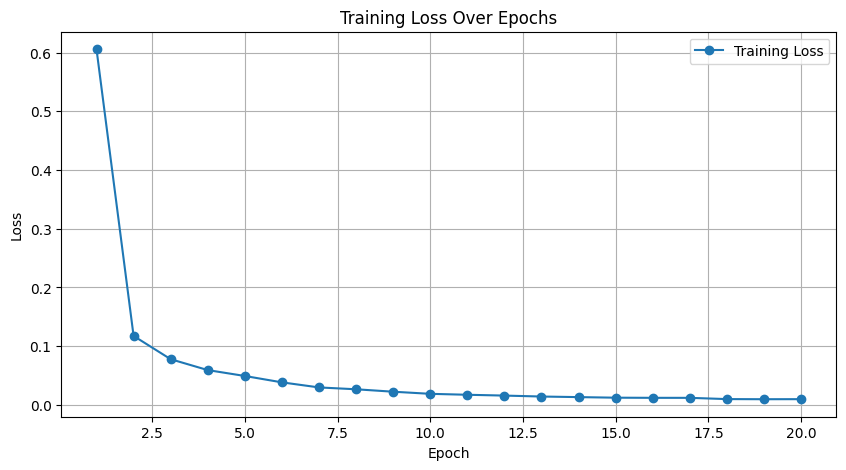

In [11]:
# 損失の推移をグラフ化
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.show()